# Study bias

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022-04-21
- update : 2022-04-21



In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%matplotlib inline
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
import seaborn as sns 
import itertools
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))

In [24]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.left': True,
          'figure.figsize': [18, 10],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

# Read mock dataset

In [25]:
df =pd.read_csv("mock_lsst.csv",index_col=0)

In [26]:
df

,m_obs_u,m_obs_g,m_obs_r,m_obs_i,m_obs_z,m_obs_y,m_obs_err_u,m_obs_err_g,m_obs_err_r,m_obs_err_i,m_obs_err_z,m_obs_err_y,redshifts,types,typenames
0,24.121253,23.682399,22.732664,21.760612,21.387662,21.167022,0.061651,0.067226,0.072345,0.067425,0.066002,0.071466,0.754783,1,Spiral 1
1,24.368534,23.799042,23.225134,22.826073,22.916760,22.842173,0.113034,0.109405,0.109510,0.112609,0.112472,0.108207,0.202635,4,Starburst 2
2,25.134148,25.080284,23.815267,23.253687,23.199807,22.886999,0.168432,0.174367,0.185373,0.165084,0.172020,0.168341,0.390223,2,Spiral 2
3,20.375814,19.652910,18.778945,18.453302,18.225431,18.115650,0.004410,0.004682,0.004808,0.004963,0.004778,0.005136,0.361396,2,Spiral 2
4,23.973614,23.612861,23.147131,22.698004,22.688277,22.586633,0.088914,0.090791,0.084437,0.088501,0.081487,0.098120,0.215496,4,Starburst 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,26.165706,24.093350,22.500488,21.341332,20.920425,20.642209,0.064930,0.059484,0.063189,0.062550,0.059036,0.060524,0.665550,0,Elliptical 1
19996,22.508140,22.175246,21.511871,21.162974,21.139776,21.040131,0.025340,0.027322,0.025385,0.027509,0.027004,0.026646,0.461514,3,Starburst 1
19997,27.172635,25.166559,23.488856,22.237610,21.743397,21.525413,0.131675,0.142764,0.132426,0.135734,0.131553,0.131691,0.745137,0,Elliptical 1
19998,23.138626,22.859163,22.530698,22.431895,22.040158,21.782366,0.064695,0.068356,0.059287,0.066218,0.059495,0.060966,1.242486,4,Starburst 2


In [27]:
target=df["types"].values

In [28]:
target_numbers = np.unique(target)
target_numbers

array([0, 1, 2, 3, 4, 5, 6, 7])

In [29]:
label_names=np.unique(df["typenames"].values)
label_names

array(['Elliptical 1', 'Spiral 1', 'Spiral 2', 'Starburst 1',
       'Starburst 2', 'Starburst 3', 'Starburst 4', 'Starburst 5'],
      dtype=object)

In [30]:
nt=len(target_numbers)

# Compute colors

In [31]:
df["u-g"] = df["m_obs_u"]-df["m_obs_g"]
df["g-r"] = df["m_obs_g"]-df["m_obs_r"]
df["r-i"] = df["m_obs_r"]-df["m_obs_i"]
df["i-z"] = df["m_obs_i"]-df["m_obs_z"]
df["z-y"] = df["m_obs_z"]-df["m_obs_y"]

In [32]:
#data=df[ ["u-g","g-r","r-i","i-z","z-y"] ]

In [36]:
df.rename(columns={"m_obs_u": "m_u",
                   "m_obs_g": "m_g",
                   "m_obs_r": "m_r",
                   "m_obs_i": "m_i",
                   "m_obs_z": "m_z",
                   "m_obs_y": "m_y",
                   "m_obs_err_u": "me_u",
                   "m_obs_err_g": "me_g",
                   "m_obs_err_r": "me_r",
                   "m_obs_err_i": "me_i",
                   "m_obs_err_z": "me_z",
                   "m_obs_err_y": "me_y",          
                  }, inplace = True)

In [37]:
df

,m_u,m_g,m_r,m_i,m_z,m_y,me_u,me_g,me_r,me_i,me_z,me_y,redshifts,types,typenames,u-g,g-r,r-i,i-z,z-y
0,24.121253,23.682399,22.732664,21.760612,21.387662,21.167022,0.061651,0.067226,0.072345,0.067425,0.066002,0.071466,0.754783,1,Spiral 1,0.438855,0.949735,0.972051,0.372950,0.220640
1,24.368534,23.799042,23.225134,22.826073,22.916760,22.842173,0.113034,0.109405,0.109510,0.112609,0.112472,0.108207,0.202635,4,Starburst 2,0.569492,0.573908,0.399062,-0.090688,0.074587
2,25.134148,25.080284,23.815267,23.253687,23.199807,22.886999,0.168432,0.174367,0.185373,0.165084,0.172020,0.168341,0.390223,2,Spiral 2,0.053865,1.265017,0.561580,0.053880,0.312808
3,20.375814,19.652910,18.778945,18.453302,18.225431,18.115650,0.004410,0.004682,0.004808,0.004963,0.004778,0.005136,0.361396,2,Spiral 2,0.722904,0.873965,0.325644,0.227871,0.109781
4,23.973614,23.612861,23.147131,22.698004,22.688277,22.586633,0.088914,0.090791,0.084437,0.088501,0.081487,0.098120,0.215496,4,Starburst 2,0.360754,0.465730,0.449127,0.009727,0.101644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,26.165706,24.093350,22.500488,21.341332,20.920425,20.642209,0.064930,0.059484,0.063189,0.062550,0.059036,0.060524,0.665550,0,Elliptical 1,2.072356,1.592862,1.159156,0.420907,0.278215
19996,22.508140,22.175246,21.511871,21.162974,21.139776,21.040131,0.025340,0.027322,0.025385,0.027509,0.027004,0.026646,0.461514,3,Starburst 1,0.332893,0.663376,0.348897,0.023197,0.099645
19997,27.172635,25.166559,23.488856,22.237610,21.743397,21.525413,0.131675,0.142764,0.132426,0.135734,0.131553,0.131691,0.745137,0,Elliptical 1,2.006076,1.677703,1.251245,0.494214,0.217984
19998,23.138626,22.859163,22.530698,22.431895,22.040158,21.782366,0.064695,0.068356,0.059287,0.066218,0.059495,0.060966,1.242486,4,Starburst 2,0.279464,0.328465,0.098802,0.391737,0.257792


# Binning in redshifts

In [17]:
zstep = 0.5
zmin =0
zmax =3

In [18]:
zbinsmin = np.arange(zmin,zmax,zstep)

In [19]:
zbinsmax = zbinsmin + zstep

In [79]:
def get_histos_in_bins(df,x_str,y_str,NXBINS=10,NYBINS=50,XMIN=0,XMAX=3):
    """
    get_magnitudes_in_bins(df,z1,z2)
    
    """
    
    X = df[x_str].values
    Y = df[y_str].values
    YMIN = Y.min()
    YMAX = Y.max()
    
    
    H,xedges,yedges = np.histogram2d(x=X,y=Y,bins=[NXBINS,NYBINS],
                                     range=[ [XMIN,XMAX],[YMIN,YMAX]])
    return H,xedges,yedges
    

In [80]:
h,x,y = get_histos_in_bins(df,x_str="redshifts",y_str="m_i",NXBINS=10)

In [93]:
ht = h.T

In [94]:
ht.shape

(50, 10)

In [95]:
NXBINS = ht.shape[1]

In [132]:
palette = itertools.cycle(sns.color_palette("hls", NXBINS))

Text(0.5, 0, 'm(i) (mag)')

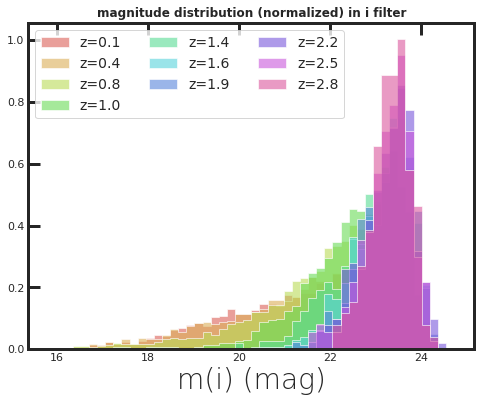

In [147]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
for nx in range(NXBINS):
    counts = ht[:,nx]
    z= (x[nx]+x[nx+1])/2.
    label = f"z={z:.1f}"
    ax.hist(y[:-1],  bins = y , weights=counts, color=next(palette),density=True,alpha=0.6,histtype="stepfilled",label=label)
ax.legend(loc=2,ncol=3)  
ax.set_title("magnitude distribution (normalized) in i filter",fontweight="bold")
ax.set_xlabel("m(i) (mag)")

In [138]:
im

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.07729942, 0.11594913, 0.15459884, 0.27054797, 0.38649709,
        0.65704506, 0.88894331, 0.88894331, 1.00489244, 0.57974564,
        0.46379651, 0.07729942, 0.03864971, 0.        , 0.        ]),
 array([15.81094815, 15.9893855 , 16.16782285, 16.3462602 , 16.52469755,
        16.7031349 , 16.88157226, 17.06000961, 17.23844696, 17.41688431,
        17.59532166, 17.77375901, 17.95219636, 18.13063371, 18.30907106,
        18.48750841, 18.66594576, 18.84438311, 19.02282046, 19.20125781,
        19.37969516, 19.55